In [1]:
# load the packages and functions

# auto-reload edited moduleås
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
import matplotlib.dates as mdates
from itertools import cycle

## plan of action

- show the anomaly month by month compared to the climatology for those two years (when is the anomaly the greatest? I anticipate DJF)
- compare transformations for JFM for the two years (lead up to sea ice maximum?)
- how much did each term contribute to the heating for those months? (ie similar to stacked bar)

In [3]:
# load the climatology for those two years

In [4]:
path = "/scratch/mmurakami/ASTE_270/ASTER1_offline_terms/"
fn = path + "wmt_gates_monthly_and_climatology_2006_2017_BarentsS.npz"

with np.load(fn, allow_pickle=True) as D:
    out  = D["out"].item()   # dict keyed by ts_key
    clim = D["clim"].item()  # dict with "meta" and "monthly"

# examples
print(type(out), len(out))
print(clim["meta"].keys())
print(clim["monthly"][1].keys())  # January fields

<class 'dict'> 144
dict_keys(['years', 'gateT_keys', 'gateS_keys'])
dict_keys(['GT', 'GS', 'gatesT', 'gatesS', 'Tbudg', 'Sbudg'])


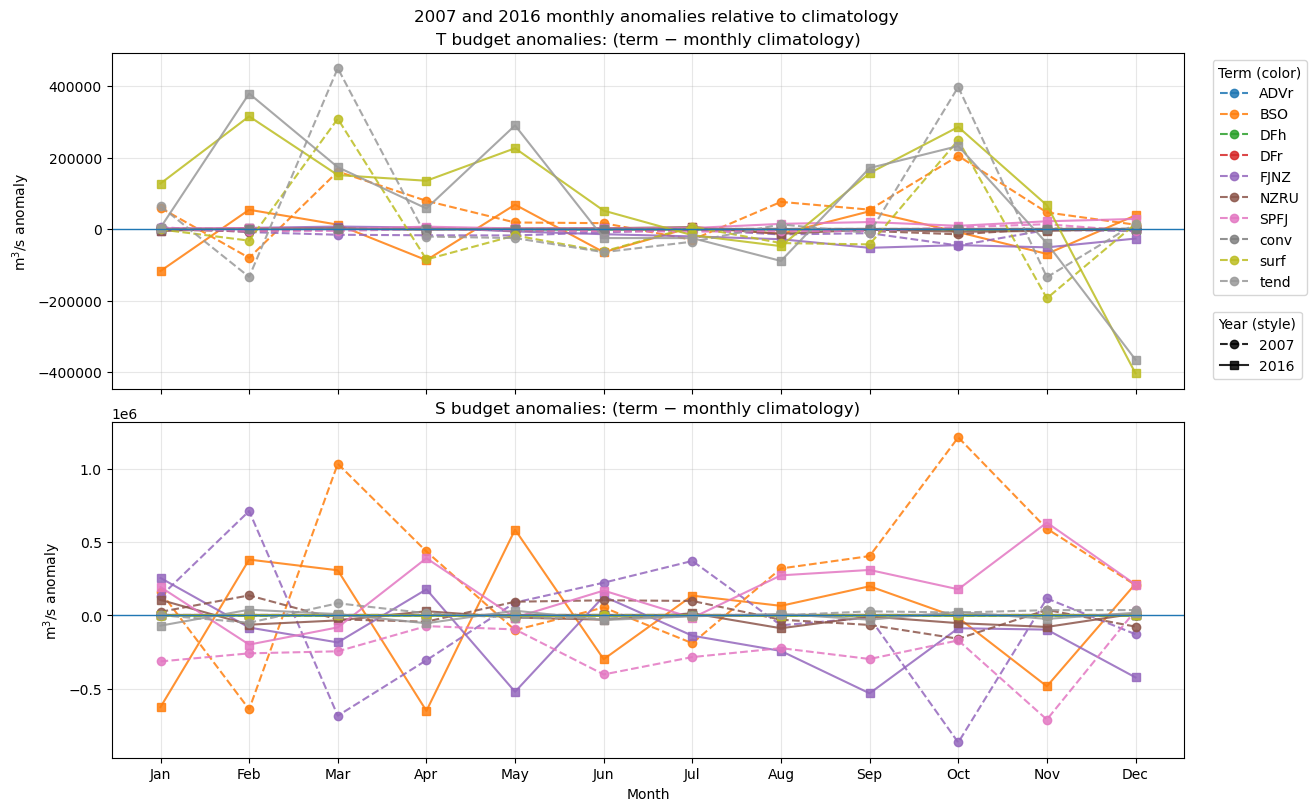

In [5]:
# -----------------------------
# build time axis from out metadata
# -----------------------------
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x_full = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])

def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def collect_series(budg_name, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            if np.ndim(v) > 0:
                v = np.nansum(np.asarray(v, dtype=float))
            y.append(v)
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys, T_vals = collect_series("Tbudg", drop_fn=drop_terms)
S_keys, S_vals = collect_series("Sbudg", drop_fn=drop_terms)

# -----------------------------
# consistent color mapping by TERM (same term => same color)
# -----------------------------
all_terms_union = sorted(set(T_keys).union(S_keys))

palette12 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#393b79", "#637939",
]

def is_tendency(k):
    s = _norm_key(k)
    return ("tend" in s) or ("tendency" in s) or ("ddt" in s) or (s.startswith("dt"))

term_color = {}
for k in all_terms_union:
    if is_tendency(k):
        term_color[k] = "0.6"  # gray

remaining = [k for k in all_terms_union if k not in term_color]
cycler = cycle(palette12)
for k in remaining:
    term_color[k] = next(cycler)

# -----------------------------
# monthly anomaly helper: (term - monthly climatology)
# -----------------------------
def monthly_anom_for_year(y, x_index, year):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    clim = s.groupby(s.index.month).mean()          # index 1..12
    s_anom = s - s.index.month.map(clim)            # subtract month climatology
    s_year = s_anom[s_anom.index.year == year]

    out12 = np.full(12, np.nan, dtype=float)
    if len(s_year) > 0:
        out12[s_year.index.month.values - 1] = s_year.values
    return out12

m_axis = np.arange(1, 13)

# -----------------------------
# plot: anomalies with SAME color per term, style distinguishes year
# -----------------------------
fig, (axT, axS) = plt.subplots(2, 1, figsize=(13, 8), sharex=True, constrained_layout=True)

# style by year (color fixed by term)
style = {
    2007: dict(linestyle="--", marker="o", alpha=0.85),
    2016: dict(linestyle="-",  marker="s", alpha=0.85),
}

# T anomalies
for k in T_keys:
    c = term_color.get(k, None)
    axT.plot(m_axis, monthly_anom_for_year(T_vals[k], x_full, 2007), color=c, label=f"{k}", **style[2007])
    axT.plot(m_axis, monthly_anom_for_year(T_vals[k], x_full, 2016), color=c, label="_nolegend_", **style[2016])

axT.axhline(0, linewidth=1)
axT.set_ylabel("m$^3$/s anomaly")
axT.set_title("T budget anomalies: (term − monthly climatology)")
axT.grid(alpha=0.3)

# S anomalies
for k in S_keys:
    c = term_color.get(k, None)
    axS.plot(m_axis, monthly_anom_for_year(S_vals[k], x_full, 2007), color=c, label=f"{k}", **style[2007])
    axS.plot(m_axis, monthly_anom_for_year(S_vals[k], x_full, 2016), color=c, label="_nolegend_", **style[2016])

axS.axhline(0, linewidth=1)
axS.set_ylabel("m$^3$/s anomaly")
axS.set_title("S budget anomalies: (term − monthly climatology)")
axS.grid(alpha=0.3)

axS.set_xlabel("Month")
axS.set_xticks(m_axis)
axS.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

# legend: one entry per term (color), plus a small year-style legend
leg_terms_T = axT.legend(title="Term (color)", bbox_to_anchor=(1.02, 1), loc="upper left")
axT.add_artist(leg_terms_T)

h07, = axT.plot([], [], color="k", **style[2007], label="2007")
h16, = axT.plot([], [], color="k", **style[2016], label="2016")
axT.legend(handles=[h07, h16], title="Year (style)", bbox_to_anchor=(1.02, 0.25), loc="upper left")

plt.suptitle("2007 and 2016 monthly anomalies relative to climatology")
plt.show()

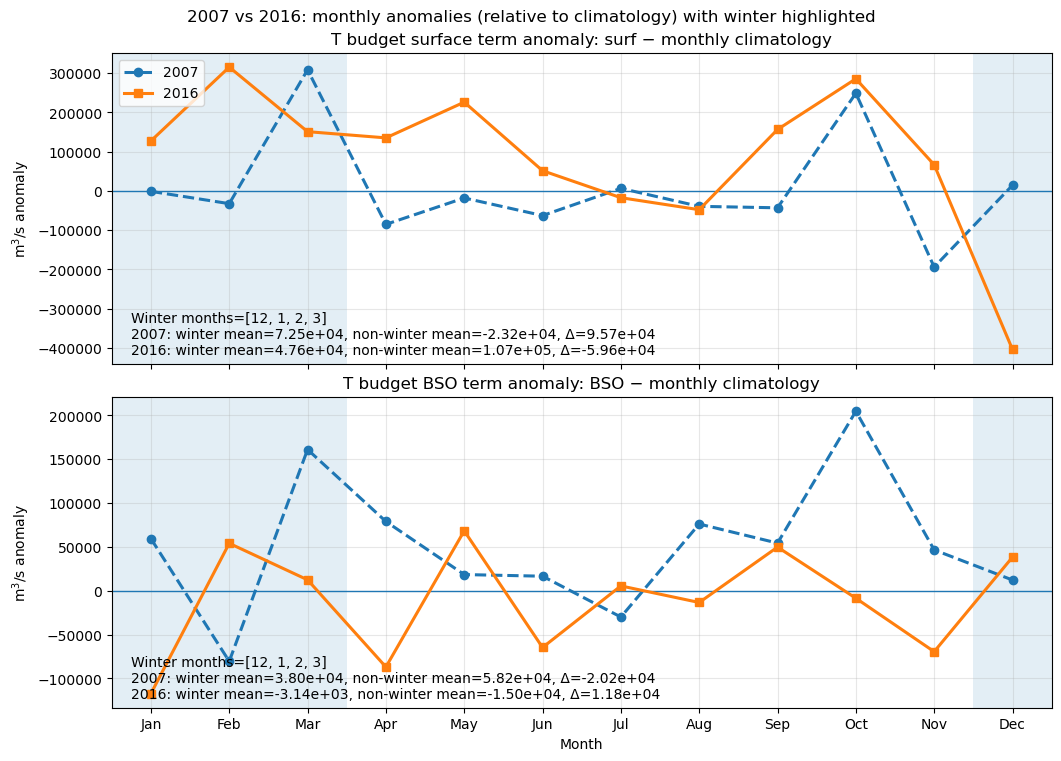

In [6]:
# -----------------------------
# helpers
# -----------------------------
def as_scalar(v):
    v = np.asarray(v)
    return float(np.nansum(v)) if v.ndim else float(v)

def build_sorted_time(out):
    ts_names = list(out.keys())
    triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
    triples.sort()
    ts_sorted = [ts for (_, _, ts) in triples]
    x_full = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])
    return ts_sorted, x_full

def extract_term_series(out, ts_sorted, term, budg="Tbudg"):
    y = []
    for ts in ts_sorted:
        v = out[ts].get(budg, {}).get(term, np.nan)
        y.append(as_scalar(v))
    return np.asarray(y, dtype=float)

def month_climatology(y, x_index):
    s = pd.Series(y, index=x_index)
    return s.groupby(s.index.month).mean()  # 1..12

def year_month_vector(y, x_index, year):
    s = pd.Series(y, index=x_index)
    s_year = s[s.index.year == year]
    out12 = np.full(12, np.nan)
    if len(s_year):
        out12[s_year.index.month.values - 1] = s_year.values
    return out12

def monthly_anom_vector(y_full, x_index, year):
    """12-length (year month - climatology of that month)."""
    s = pd.Series(np.asarray(y_full, dtype=float), index=x_index)
    clim = s.groupby(s.index.month).mean()
    s_anom = s - s.index.month.map(clim)
    s_year = s_anom[s_anom.index.year == year]
    out12 = np.full(12, np.nan)
    if len(s_year):
        out12[s_year.index.month.values - 1] = s_year.values
    return out12

def winter_stats(arr, winter_months):
    m = np.arange(1, 13)
    wmask = np.array([(mm in winter_months) for mm in m])
    w = np.nanmean(arr[wmask])
    nw = np.nanmean(arr[~wmask])
    return w, nw, (w - nw)

# -----------------------------
# build series + anomalies
# -----------------------------
ts_sorted, x_full = build_sorted_time(out)

surf_full = extract_term_series(out, ts_sorted, term="surf", budg="Tbudg")
bso_full  = extract_term_series(out, ts_sorted, term="BSO",  budg="Tbudg")

surf2007 = monthly_anom_vector(surf_full, x_full, 2007)
surf2016 = monthly_anom_vector(surf_full, x_full, 2016)
bso2007  = monthly_anom_vector(bso_full,  x_full, 2007)
bso2016  = monthly_anom_vector(bso_full,  x_full, 2016)

m = np.arange(1, 13)

# winter highlight (edit if you want DJF only)
winter_months = [12, 1, 2, 3]  # DJFM
w07_s, nw07_s, d07_s = winter_stats(surf2007, winter_months)
w16_s, nw16_s, d16_s = winter_stats(surf2016, winter_months)
w07_b, nw07_b, d07_b = winter_stats(bso2007,  winter_months)
w16_b, nw16_b, d16_b = winter_stats(bso2016,  winter_months)

# -----------------------------
# plot: 2 panels (surf anomaly, BSO anomaly), winter shaded
# -----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10.5, 7.5), sharex=True, constrained_layout=True)

for ax in (ax1, ax2):
    for mm in winter_months:
        ax.axvspan(mm - 0.5, mm + 0.5, alpha=0.12)
    ax.axhline(0, linewidth=1)
    ax.grid(alpha=0.3)

# surf anomalies
ax1.plot(m, surf2007, marker="o", linestyle="--", linewidth=2.2, label="2007")
ax1.plot(m, surf2016, marker="s", linestyle="-",  linewidth=2.2, label="2016")
ax1.set_ylabel("m$^3$/s anomaly")
ax1.set_title("T budget surface term anomaly: surf − monthly climatology")
ax1.legend(loc="upper left")
ax1.text(
    0.02, 0.02,
    f"Winter months={winter_months}\n"
    f"2007: winter mean={w07_s:.2e}, non-winter mean={nw07_s:.2e}, Δ={d07_s:.2e}\n"
    f"2016: winter mean={w16_s:.2e}, non-winter mean={nw16_s:.2e}, Δ={d16_s:.2e}",
    transform=ax1.transAxes, va="bottom"
)

# BSO anomalies
ax2.plot(m, bso2007, marker="o", linestyle="--", linewidth=2.2, label="2007")
ax2.plot(m, bso2016, marker="s", linestyle="-",  linewidth=2.2, label="2016")
ax2.set_ylabel("m$^3$/s anomaly")
ax2.set_title("T budget BSO term anomaly: BSO − monthly climatology")
ax2.text(
    0.02, 0.02,
    f"Winter months={winter_months}\n"
    f"2007: winter mean={w07_b:.2e}, non-winter mean={nw07_b:.2e}, Δ={d07_b:.2e}\n"
    f"2016: winter mean={w16_b:.2e}, non-winter mean={nw16_b:.2e}, Δ={d16_b:.2e}",
    transform=ax2.transAxes, va="bottom"
)

ax2.set_xlabel("Month")
ax2.set_xticks(m)
ax2.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax2.set_xlim(0.5, 12.5)

plt.suptitle("2007 vs 2016: monthly anomalies (relative to climatology) with winter highlighted")
plt.show()

## answer very basic questions here

- what is the sea ice fraction for those two years?
- Ice was X (percentile), OHC change was Y (percentile).”
- Of total annual OHC tendency, surface contributed A%, BSO contributed B%, remainder C%.”
- Peak months were …; BSO led/lags SIC by … months.”
- Spatially, anomalies sit in … region/layer.


In [7]:
# what was the sea ice fraction for JFM for those two years? compared to average?

# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),12))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2


        # get the total SIarea for that time
        if i in [0,1,2]:  # Jan-March
            SIareas[iy,i] = np.nansum(SIarea[i,:,:])
        else:
            SIareas[iy,i] = np.full(np.nansum(SIarea[i,:,:]).shape,np.nan)
        #alldatetimes = np.append(alldatetimes,datetimes[i])

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [8]:
SIareas = SIareas[3:]


In [9]:
SIareay07 = SIareas[1]
SIareay16 = SIareas[-2]


In [10]:
print("2007 SIarea:",np.nanmean(SIareay07))
print("2016 SIarea:",np.nanmean(SIareay16))


2007 SIarea: 345463960888.9584
2016 SIarea: 233056724717.58716


In [11]:
# -----------------------------
# settings
# -----------------------------
years_want = [2007, 2016]

dstart = 0
dterm  = 50
tref   = 0.0  # degC

rcp = myparms["rcp"]  # J/m^3/degC
DRF3d = np.tile(mygrid["DRF"][:, np.newaxis, np.newaxis], (1, ny, nx))

AREA = RAC * mymsk  # for basin-mean diagnostics

# -----------------------------
# helper: read THETA at timestep string
# -----------------------------
def read_theta(ts):
    file_name = "state_3d_set1"
    meta = parsemeta(os.path.join(dirState, f"{file_name}.{ts}.meta"))
    fldlist = np.array(meta["fldList"])
    idx = np.where(fldlist == "THETA")[0]
    if len(idx) == 0:
        raise KeyError(f"THETA not in fldList for ts={ts}. Available: {list(fldlist)}")
    rec_theta = int(idx[0])
    THETAi, its, meta2 = rdmds(os.path.join(dirState, file_name), [int(ts)],
                              returnmeta=True, rec=rec_theta)
    return np.asarray(THETAi).reshape((nz, ny, nx))

def compute_ohc_2d_from_theta(TH):
    TH = np.asarray(TH, dtype=float) * mymsk[np.newaxis, :, :]          # mask
    heat = (TH - tref) * rcp                                            # J/m^3
    heat = heat * DRF3d                                                 # J/m^2 per layer
    heat = heat[dstart:dterm]                                           # depth slice
    ohc_2d = np.nansum(heat, axis=0) * mymsk                             # J/m^2
    return ohc_2d * 1e-6                                                # MJ/m^2

def area_mean(field2d, area2d):
    field2d = np.asarray(field2d, dtype=float)
    w = np.where(np.isfinite(field2d), area2d, 0.0)
    den = np.nansum(w)
    return np.nansum(field2d * w) / den if den > 0 else np.nan

# -----------------------------
# compute Jan->Dec change for each year
# -----------------------------
dOHC = {}  # dOHC[year] = (ny,nx) map in MJ/m^2

for Y in years_want:
    print("YEAR", Y)

    times = {str(Y): np.arange(1, 13)}
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    if len(tsstr) < 12:
        raise ValueError(f"Expected 12 monthly timesteps for {Y}, got {len(tsstr)}")

    # assume tsstr[0] is Jan and tsstr[11] is Dec for that year
    ts_jan = tsstr[0]
    ts_dec = tsstr[11]

    TH_jan = read_theta(ts_jan)
    TH_dec = read_theta(ts_dec)

    OHC_jan = compute_ohc_2d_from_theta(TH_jan)  # MJ/m^2
    OHC_dec = compute_ohc_2d_from_theta(TH_dec)  # MJ/m^2

    dmap = OHC_dec - OHC_jan                     # MJ/m^2
    dOHC[Y] = dmap

    # basin mean and total-J diagnostics
    mean_d = area_mean(dmap, AREA)               # MJ/m^2
    total_dJ = np.nansum((dmap * 1e6) * AREA)    # J

    print(f"{Y}: ts_jan={ts_jan}, ts_dec={ts_dec}")
    print(f"{Y}: ΔOHC (Dec - Jan) area-mean = {mean_d:.3f} MJ/m^2")
    print(f"{Y}: ΔH   (Dec - Jan) total     = {total_dJ:.3e} J")

# Example access:
# dOHC[2007] is your (ny,nx) map for Dec2007 - Jan2007
# dOHC[2016] is your (ny,nx) map for Dec2016 - Jan2016

YEAR 2007
2007: ts_jan=0000262944, ts_dec=0000311040
2007: ΔOHC (Dec - Jan) area-mean = 472.461 MJ/m^2
2007: ΔH   (Dec - Jan) total     = 6.709e+20 J
YEAR 2016
2016: ts_jan=0000736272, ts_dec=0000784512
2016: ΔOHC (Dec - Jan) area-mean = 678.698 MJ/m^2
2016: ΔH   (Dec - Jan) total     = 9.637e+20 J


In [12]:
# -----------------------------
# settings
# -----------------------------
years_want = [2007, 2016]

dstart = 0
dterm  = 50
tref   = 0.0  # degC

rcp = myparms["rcp"]  # J/m^3/degC
DRF3d = np.tile(mygrid["DRF"][:, np.newaxis, np.newaxis], (1, ny, nx))
AREA  = RAC * mymsk  # basin area weights

# -----------------------------
# helpers
# -----------------------------
def read_theta(ts):
    file_name = "state_3d_set1"
    meta = parsemeta(os.path.join(dirState, f"{file_name}.{ts}.meta"))
    fldlist = np.array(meta["fldList"])
    idx = np.where(fldlist == "THETA")[0]
    if len(idx) == 0:
        raise KeyError(f"THETA not in fldList for ts={ts}. Available: {list(fldlist)}")
    rec_theta = int(idx[0])
    THETAi, its, meta2 = rdmds(
        os.path.join(dirState, file_name), [int(ts)],
        returnmeta=True, rec=rec_theta
    )
    return np.asarray(THETAi).reshape((nz, ny, nx))

def compute_ohc_2d_from_theta(TH):
    TH = np.asarray(TH, dtype=float) * mymsk[np.newaxis, :, :]
    heat = (TH - tref) * rcp          # J/m^3
    heat = heat * DRF3d               # J/m^2 per layer
    heat = heat[dstart:dterm]         # depth slice
    ohc_2d = np.nansum(heat, axis=0) * mymsk  # J/m^2
    return ohc_2d * 1e-6              # MJ/m^2

def area_mean(field2d, area2d):
    field2d = np.asarray(field2d, dtype=float)
    w = np.where(np.isfinite(field2d), area2d, 0.0)
    den = np.nansum(w)
    return np.nansum(field2d * w) / den if den > 0 else np.nan

def get_ts_for_months(year, months=(1, 2, 3)):
    """Return (ts_list, dt_list) for requested months, sorted by datetime."""
    times = {str(year): np.asarray(months, dtype=int)}
    tsstr, dts = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
    # sort in time (just in case)
    order = np.argsort(np.asarray(dts))
    tsstr = np.asarray(tsstr)[order]
    dts   = np.asarray(dts)[order]
    return list(tsstr), list(dts)

# -----------------------------
# compute Jan->Mar change for each year (JFM)
# -----------------------------
dOHC_JFM = {}  # dOHC_JFM[year] = (ny,nx) map in MJ/m^2

for Y in years_want:
    print("YEAR", Y)

    ts_list, dt_list = get_ts_for_months(Y, months=(1, 2, 3))
    if len(ts_list) != 3:
        raise ValueError(f"Expected 3 timesteps for JFM in {Y}, got {len(ts_list)}: {ts_list}")

    ts_jan = ts_list[0]
    ts_mar = ts_list[2]

    TH_jan = read_theta(ts_jan)
    TH_mar = read_theta(ts_mar)

    OHC_jan = compute_ohc_2d_from_theta(TH_jan)  # MJ/m^2
    OHC_mar = compute_ohc_2d_from_theta(TH_mar)  # MJ/m^2

    dmap = OHC_mar - OHC_jan                     # MJ/m^2
    dOHC_JFM[Y] = dmap

    mean_d  = area_mean(dmap, AREA)              # MJ/m^2
    total_dJ = np.nansum((dmap * 1e6) * AREA)    # J

    print(f"{Y}: ts_jan={ts_jan}, ts_mar={ts_mar}")
    print(f"{Y}: ΔOHC (Mar - Jan) area-mean = {mean_d:.3f} MJ/m^2")
    print(f"{Y}: ΔH   (Mar - Jan) total     = {total_dJ:.3e} J")

# Example:
# dOHC_JFM[2007] is your (ny,nx) map for Mar2007 - Jan2007
# dOHC_JFM[2016] is your (ny,nx) map for Mar2016 - Jan2016

YEAR 2007
2007: ts_jan=0000262944, ts_mar=0000271440
2007: ΔOHC (Mar - Jan) area-mean = -489.846 MJ/m^2
2007: ΔH   (Mar - Jan) total     = -6.956e+20 J
YEAR 2016
2016: ts_jan=0000736272, ts_mar=0000744912
2016: ΔOHC (Mar - Jan) area-mean = -414.954 MJ/m^2
2016: ΔH   (Mar - Jan) total     = -5.892e+20 J


In [13]:
# great, the ocean gained heat in this year, this is what we expected
# how much did the terms contribute?
# we can look specifically at JFM to see this

In [14]:
# take an average of out for JFM for the GT for both years JFM

# out['0000214848']['GT']

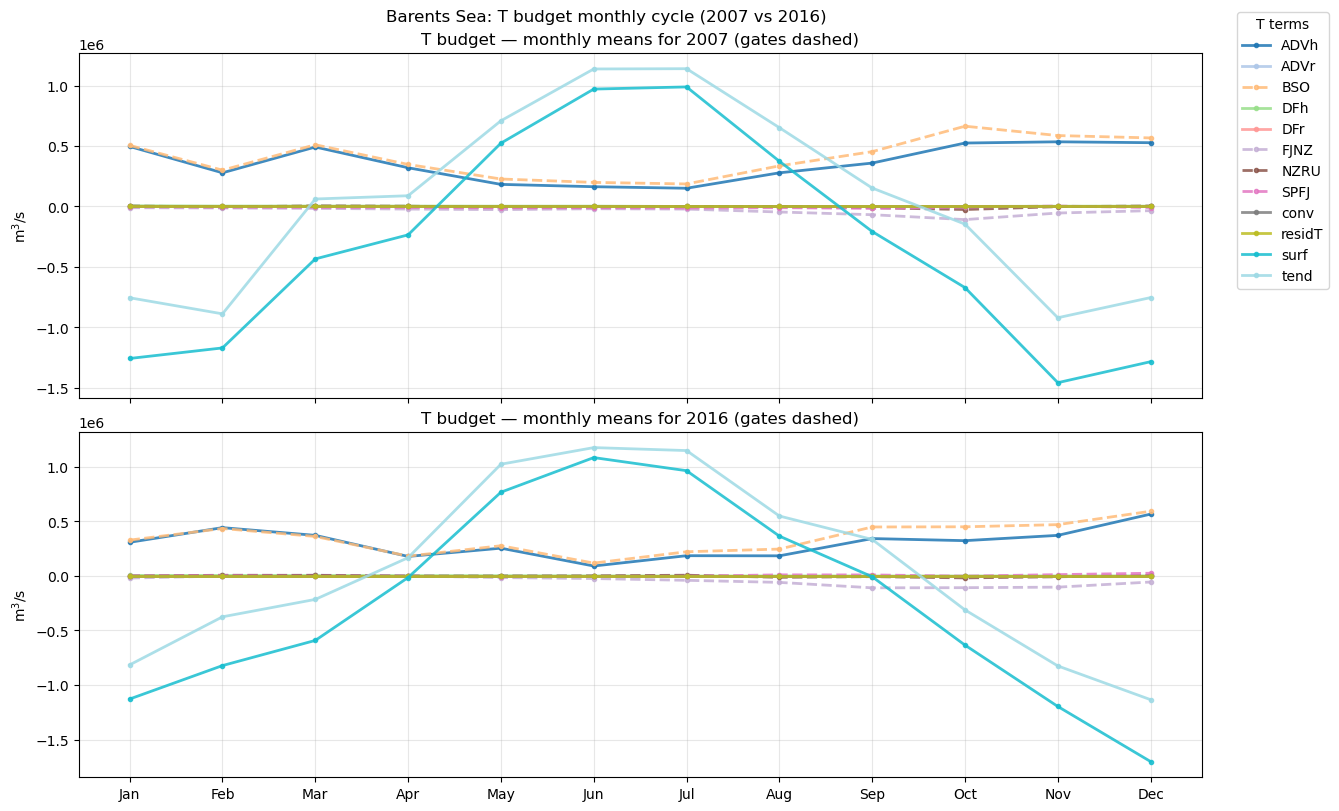

In [15]:
# -----------------------------
# build sorted monthly axis from out metadata
# -----------------------------
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])

months = np.arange(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

gate_keys = {"BSO", "FJNZ", "SPFJ", "NZRU"}

def _as_scalar(v):
    v = np.asarray(v)
    return float(np.nansum(v)) if v.ndim else float(v)

# -----------------------------
# collect Tbudg series across all months (for color consistency)
# -----------------------------
def collect_series_T(out):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get("Tbudg", {}).keys()})
    vals_by_key = {}
    for k in all_keys:
        vals_by_key[k] = np.asarray(
            [_as_scalar(out[ts].get("Tbudg", {}).get(k, np.nan)) for ts in ts_sorted],
            dtype=float
        )
    return all_keys, vals_by_key

T_keys, T_vals = collect_series_T(out)

# -----------------------------
# for a given year: build monthly mean vector (Jan..Dec) of each T term
# (averaged across all entries in that year; here it's just 1 per month)
# -----------------------------
def year_monthly_vector(out, year, term_series):
    s = pd.Series(np.asarray(term_series, dtype=float), index=x)
    s_year = s[s.index.year == year]
    yvec = s_year.groupby(s_year.index.month).mean().reindex(months).to_numpy()
    return yvec

def build_year_monthly_dict(out, year, T_vals):
    return {k: year_monthly_vector(out, year, v) for k, v in T_vals.items()}

T_2007 = build_year_monthly_dict(out, 2007, T_vals)
T_2016 = build_year_monthly_dict(out, 2016, T_vals)

# -----------------------------
# consistent unique colors across all T terms
# -----------------------------
all_terms = list(T_keys)
cmap = plt.cm.tab20
colors = {k: cmap(i / max(1, len(all_terms) - 1)) for i, k in enumerate(all_terms)}

def plot_terms(ax, monthly_dict, title):
    for k, y in monthly_dict.items():
        ls = "--" if k in gate_keys else "-"
        ax.plot(months, y, marker=".", label=str(k), alpha=0.85,
                color=colors.get(k, None), linestyle=ls, linewidth=2.0)
    ax.set_ylabel("m$^3$/s")
    ax.set_title(title)
    ax.grid(alpha=0.3)

# -----------------------------
# plot: only T budget, years 2007 and 2016
# -----------------------------
fig, (axA, axB) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, constrained_layout=True)

plot_terms(axA, T_2007, "T budget — monthly means for 2007 (gates dashed)")
plot_terms(axB, T_2016, "T budget — monthly means for 2016 (gates dashed)")

axB.set_xticks(months)
axB.set_xticklabels(month_labels)

# one shared legend (outside)
handles, labels = axA.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left", title="T terms")

plt.suptitle("Barents Sea: T budget monthly cycle (2007 vs 2016)")
plt.show()

In [16]:
# also load the bins again so we have them locally
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

## load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

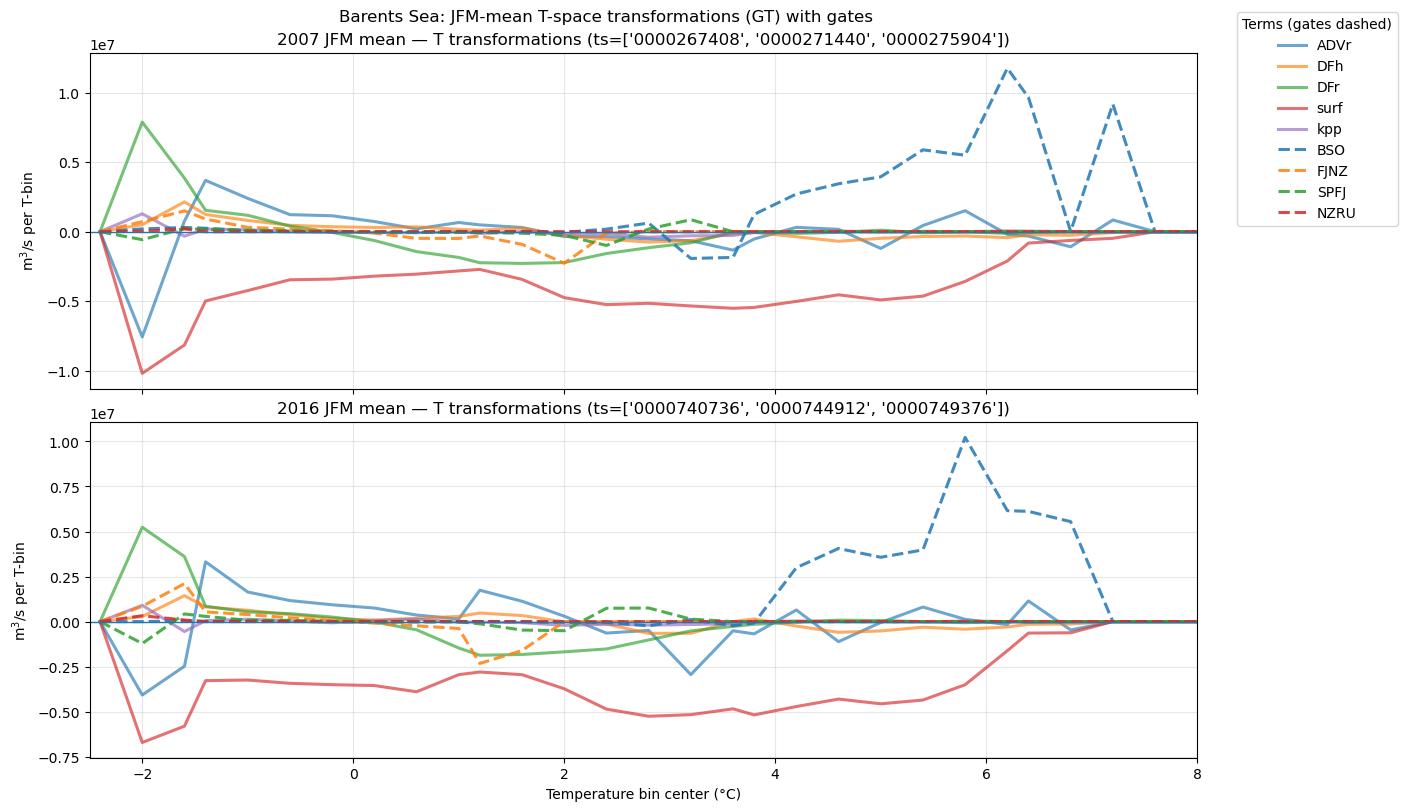

In [19]:
# no we want the actual WMT
# ----------------------------
# configuration (edit if your GT ordering differs)
# ----------------------------
TERM_ORDER  = ["ADVr", "DFh", "DFr", "surf", "kpp"]          # shared GT terms to show
TERM_IDX    = {"ADVr": 1, "DFh": 2, "DFr": 3, "surf": 4, "kpp": 5}
TERM_COLORS = {"ADVr": "C0", "DFh": "C1", "DFr": "C2", "surf": "C3", "kpp": "C4"}

GATE_KEYS = ["BSO", "FJNZ", "SPFJ", "NZRU"]  # plot only these gates (if present)

xt = boundsT.flatten()[1:-1]  # T-bin centers

# ----------------------------
# helpers
# ----------------------------
def get_year_month_ts(out, year, months=(1, 2, 3)):
    hits = []
    for ts, rec in out.items():
        if int(rec.get("year", -9999)) != int(year):
            continue
        m = int(rec.get("month", -1))
        if m in months:
            hits.append((m, ts))
    hits.sort()
    return [ts for (m, ts) in hits]

def _as_arr(v):
    a = np.asarray(v, dtype=float)
    a = np.nan_to_num(a, nan=0.0)
    return a

def jfm_mean_GT_and_gatesT(out, year):
    ts_list = get_year_month_ts(out, year, months=(1, 2, 3))
    if len(ts_list) != 3:
        raise ValueError(f"Expected 3 months (JFM) for {year}, got {len(ts_list)}: {ts_list}")

    GTs = []
    gates_stack = {g: [] for g in GATE_KEYS}

    for ts in ts_list:
        rec = out[ts]

        GT = _as_arr(rec["GT"])                    # (nTerms, nT)
        if GT.ndim != 2:
            raise ValueError(f"out[{ts}]['GT'] expected 2D (nTerms,nT), got {GT.shape}")
        if GT.shape[1] != len(xt):
            raise ValueError(f"{year}: out[{ts}]['GT'] has nT={GT.shape[1]} but xt has {len(xt)}")
        GTs.append(GT)

        gatesT = rec.get("gatesT", {})
        for g in GATE_KEYS:
            if g in gatesT:
                gates_stack[g].append(_as_arr(gatesT[g]))  # (nT,)
            else:
                gates_stack[g].append(np.zeros(len(xt), dtype=float))

    GT_mean = np.mean(np.stack(GTs, axis=0), axis=0)

    gates_mean = {}
    for g in GATE_KEYS:
        Gg = np.stack(gates_stack[g], axis=0)  # (3, nT)
        gates_mean[g] = np.mean(Gg, axis=0)

    return ts_list, GT_mean, gates_mean

def plot_GT_panel(ax, x, GT_mean, gates_mean, title, xlim=(-2.5, 8), alph=0.65):
    # shared GT terms
    for term in TERM_ORDER:
        y = _as_arr(GT_mean[TERM_IDX[term]])
        ax.plot(x, y, label=term, color=TERM_COLORS[term], alpha=alph, linewidth=2.2)

    # gates (dashed)
    for g in GATE_KEYS:
        if g not in gates_mean:
            continue
        y = _as_arr(gates_mean[g])
        if np.allclose(y, 0.0):
            continue
        ax.plot(x, y, label=g, linestyle="--", linewidth=2.2, alpha=0.85)

    ax.axhline(0, linewidth=1)
    ax.set_xlim(*xlim)
    ax.grid(alpha=0.3)
    ax.set_ylabel("m$^3$/s per T-bin")
    ax.set_title(title)

# ----------------------------
# build JFM means for 2007 and 2016
# ----------------------------
ts07, GT07, gates07 = jfm_mean_GT_and_gatesT(out, 2007)
ts16, GT16, gates16 = jfm_mean_GT_and_gatesT(out, 2016)

# ----------------------------
# plot: heat (T) transformations only, JFM average
# ----------------------------
fig, (axA, axB) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, constrained_layout=True)

plot_GT_panel(axA, xt, GT07, gates07, title=f"2007 JFM mean — T transformations (ts={ts07})")
plot_GT_panel(axB, xt, GT16, gates16, title=f"2016 JFM mean — T transformations (ts={ts16})")

axB.set_xlabel("Temperature bin center (°C)")

# single legend outside
handles, labels = axA.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left", title="Terms (gates dashed)")

plt.suptitle("Barents Sea: JFM-mean T-space transformations (GT) with gates")
plt.show()

In [44]:
# there was more heating in 2016 in general and less cooling in JFM, but why?

In [49]:
# I think this is wrong.


# --- bin centers (same length as GT_mean columns) ---
xt = 0.5 * (boundsT.flatten()[:-1] + boundsT.flatten()[1:])   # centers of boundsT
xt = xt[1:-1]  # match your earlier xt = boundsT.flatten()[1:-1]

rcp  = float(myparms["rcp"])  # J / m^3 / degC
tref = 0.0                    # choose the same tref you used for OHC

# term indices in GT (edit if your GT layout differs)
TERM_IDX = {"ADVr": 1, "DFh": 2, "DFr": 3, "surf": 4, "kpp": 5, "tend": 6}

def heat_tendency_from_Tspace_curve(G_Tbin, Tcenters, rcp, tref=0.0):
    """
    G_Tbin: shape (nT,) in m^3/s for each T-bin (bin-integrated)
    returns Hdot in J/s
    """
    G = np.asarray(G_Tbin, dtype=float)
    T = np.asarray(Tcenters, dtype=float)
    G = np.nan_to_num(G, nan=0.0)
    return rcp * float(np.sum((T - tref) * G))  # J/s

def pct_breakdown_from_GT_and_gates(GT_mean, gates_mean, xt, rcp, tref=0.0,
                                   gate_name="BSO", surf_name="surf", total_name="tend"):
    # surface contribution from GT
    Hdot_surf = heat_tendency_from_Tspace_curve(GT_mean[TERM_IDX[surf_name]], xt, rcp, tref)

    # BSO contribution from gates_mean (dashed curves)
    if gate_name not in gates_mean:
        raise KeyError(f"{gate_name} not found in gates_mean keys: {list(gates_mean.keys())}")
    Hdot_bso  = heat_tendency_from_Tspace_curve(gates_mean[gate_name], xt, rcp, tref)

    # define "total" as the GT tend curve (recommended if you want closure-style %’s)
    Hdot_tot  = heat_tendency_from_Tspace_curve(GT_mean[TERM_IDX[total_name]], xt, rcp, tref)

    if not np.isfinite(Hdot_tot) or abs(Hdot_tot) < 1e-30:
        return {"Hdot_tot": Hdot_tot, "Hdot_surf": Hdot_surf, "Hdot_bso": Hdot_bso,
                "pct_surf": np.nan, "pct_bso": np.nan, "pct_rest": np.nan}

    pct_surf = 100.0 * Hdot_surf / Hdot_tot
    pct_bso  = 100.0 * Hdot_bso  / Hdot_tot
    pct_rest = 100.0 * (Hdot_tot - Hdot_surf - Hdot_bso) / Hdot_tot

    return {"Hdot_tot": Hdot_tot, "Hdot_surf": Hdot_surf, "Hdot_bso": Hdot_bso,
            "pct_surf": pct_surf, "pct_bso": pct_bso, "pct_rest": pct_rest}

# ---- apply to your JFM means you already computed ----
xt = boundsT.flatten()[1:-1]
stats_2007 = pct_breakdown_from_GT_and_gates(GT07, gates07, xt, rcp, tref=tref, gate_name="BSO")
stats_2016 = pct_breakdown_from_GT_and_gates(GT16, gates16, xt, rcp, tref=tref, gate_name="BSO")

print("2007 JFM:")
print(f"  total Hdot = {stats_2007['Hdot_tot']:.3e} J/s")
print(f"  surf  Hdot = {stats_2007['Hdot_surf']:.3e} J/s  ({stats_2007['pct_surf']:.1f}%)")
print(f"  BSO   Hdot = {stats_2007['Hdot_bso']:.3e} J/s  ({stats_2007['pct_bso']:.1f}%)")
print(f"  rest       = {stats_2007['pct_rest']:.1f}%")

print("2016 JFM:")
print(f"  total Hdot = {stats_2016['Hdot_tot']:.3e} J/s")
print(f"  surf  Hdot = {stats_2016['Hdot_surf']:.3e} J/s  ({stats_2016['pct_surf']:.1f}%)")
print(f"  BSO   Hdot = {stats_2016['Hdot_bso']:.3e} J/s  ({stats_2016['pct_bso']:.1f}%)")
print(f"  rest       = {stats_2016['pct_rest']:.1f}%")


2007 JFM:
  total Hdot = -1.870e+16 J/s
  surf  Hdot = -8.190e+14 J/s  (4.4%)
  BSO   Hdot = 1.252e+15 J/s  (-6.7%)
  rest       = 102.3%
2016 JFM:
  total Hdot = -1.842e+16 J/s
  surf  Hdot = -7.921e+14 J/s  (4.3%)
  BSO   Hdot = 9.998e+14 J/s  (-5.4%)
  rest       = 101.1%
